In [304]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import random

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.tree import DecisionTreeClassifier,export_graphviz

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


%matplotlib inline


In [305]:
def initialization():
    train = pd.read_csv('training.tsv',sep='\t',header = None)
    train.columns = ['user','date','action']
    train['date'] = pd.to_datetime(train.date)

    train.info()

    print('Memory Usage is {} MB'.format(train.memory_usage(deep=True).sum()/1024**2))

    unique_actions = train.action.unique()

    print('# of users = {}'.format(train.user.nunique()))
    print('Unique actions: {}'.format(train.action.unique()))
    
    return train

train = initialization()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4918677 entries, 0 to 4918676
Data columns (total 3 columns):
user      object
date      datetime64[ns]
action    object
dtypes: datetime64[ns](1), object(2)
memory usage: 112.6+ MB
Memory Usage is 686.6933441162109 MB
# of users = 341568
Unique actions: ['EmailOpen' 'FormSubmit' 'Purchase' 'EmailClickthrough' 'CustomerSupport'
 'PageView' 'WebVisit']


In [306]:
def preprocessing(train):
    # Replacing user ID strings with unique numerical identifiers

    user_replace_dict = dict(zip(train.user.unique(),np.arange(len(train.user.unique()))))
    train['user'] = np.array([user_replace_dict[x] for x in train.user.values])

    # Replacing actions

    action_replace_dict = dict(zip(train.action.unique(),np.arange(len(train.action.unique()))))
    train['action'] = np.array([action_replace_dict[x] for x in train.action.values])


    # Creating an alternate dataframe to join dates

    temp = pd.DataFrame(train.groupby('user')['date'].min()).reset_index()
    temp.columns = ['user','min_date']
    temp2 = train.merge(temp,on='user')

    # Replacing date with days since initial action
    train['date'] = (temp2['date']-temp2['min_date']).values.astype('timedelta64[D]').astype(int)

    # Downcasting numerical values
    for col in train.columns:
        train[col] = pd.to_numeric(train[col],downcast='integer')

    print('Memory Usage is {0:.3} MB'.format(train.memory_usage(deep=True).sum()/1024**2))

    # Calculating first purchase date and joining to original dataframe

    first_purchase_date = train[train.action==2].groupby('user').first().reset_index()
    first_purchase_date.columns = ['user','first_purchase_date','action']

    train = train.merge(first_purchase_date.drop('action',axis=1),how='left',on='user')

    # Filter and getting rid of purchases and subsequent actions
    cond1 = (train.date<=train.first_purchase_date)&(train.action!=2)

    # Taking into account people who haven't purchased
    cond2 = np.isnan(train.first_purchase_date)

    train_without_purchase = train[cond1 | cond2]

    # Creating action-count dataframe
    temp  =train_without_purchase.groupby('user')['action'].value_counts()#.reset_index(name='count')
    temp = temp.unstack(fill_value =0)


    # Determining if the customer has purchased or not

    train_without_purchase.loc[:,'if_purchased'] = train_without_purchase.first_purchase_date.apply(lambda x: np.isfinite(x))
    if_purchased = pd.DataFrame(train_without_purchase.groupby('user').first().loc[:,'if_purchased']).reset_index()

    final_df = temp.merge(if_purchased,how='left',left_index=True,right_on='user')
    final_df.columns = ['EmailOpen', 'FormSubmit','EmailClickthrough', 'PageView', 'WebVisit','user','if_purchased']
    final_df.head()
    
    return final_df,action_replace_dict

final_df,action_replace_dict = preprocessing(train)

Memory Usage is 32.8 MB


C:\Users\Neal\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Neal\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [307]:
X = final_df[['EmailOpen', 'FormSubmit','EmailClickthrough', 'PageView', 'WebVisit']]
y = final_df['if_purchased']


Baseline AUC score is 0.604 

Confusion Matrix 
 [[70914   360]
 [ 7528   236]] 

False positives is: 360 

False negatives is: 7528 

True negatives is: 70914 

True positives is: 236 

Feature Importances: 

(0.4744073082058094, 'EmailOpen')
(0.17686530360882657, 'EmailClickthrough')
(0.17382556599148366, 'FormSubmit')
(0.095817688843618312, 'PageView')
(0.07908413335026207, 'WebVisit')


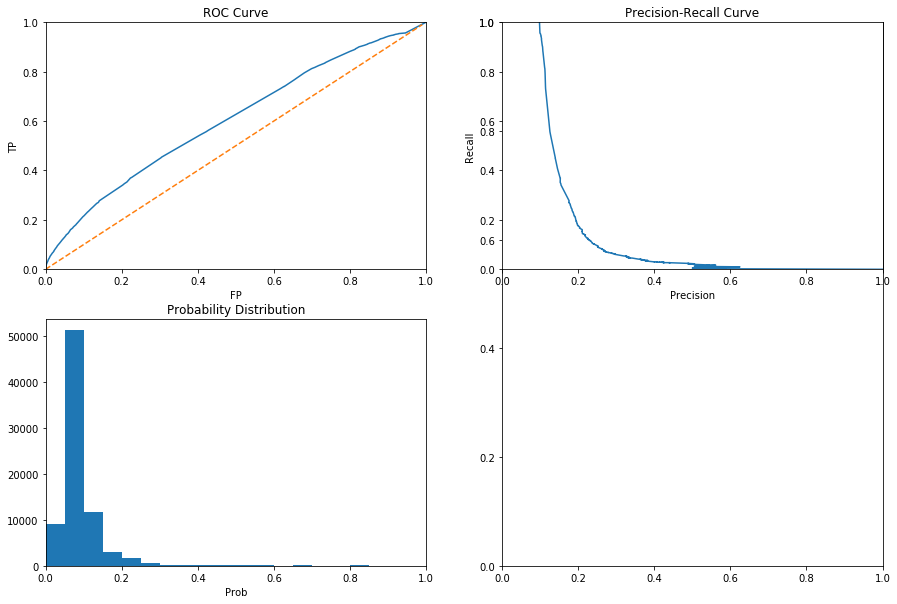

In [308]:
# Using a baseline model
def train_model(X,y,rf):  
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,stratify =y,random_state=33)

    
    y_pred = rf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    print('Baseline AUC score is {0:0.3} \n'.format(roc_auc_score(y_test,y_pred)))
    precision,recall,_ = precision_recall_curve(y_test,y_pred)

    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)

    
    ax1.plot(roc_curve(y_test,y_pred)[0],roc_curve(y_test,y_pred)[1])
    ax1.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),'--')
    plt.title('ROC Curve')
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.subplot(122)

    # Plotting Precision Recall Curve
    ax2 = fig.add_subplot(222)

    ax2.plot(precision,recall)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    
    # Plotting Probability Distribution
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.hist(y_pred,bins=20)
    plt.xlabel('Prob')
    plt.title('Probability Distribution')
    plt.xlim(0,1)

    # Calculating confusion matrix

    conf = confusion_matrix(y_test,rf.predict(X_test))
    print('Confusion Matrix \n {} \n'.format(conf))
    print('False positives is: {} \n'.format(conf[0,1]))
    print('False negatives is: {} \n'.format(conf[1,0]))
    print('True negatives is: {} \n'.format(conf[0,0]))
    print('True positives is: {} \n'.format(conf[1,1]))

    # Listing Feature Importances
    print('Feature Importances: \n')
    sorted_list = sorted(list(zip(rf.feature_importances_,X.columns)),reverse=True)
    [print(x) for x in sorted_list]
    
    return precision,recall,y_pred,y_test

rf = RandomForestClassifier(random_state=33)
precision,recall,y_pred,y_test = train_model(X,y,rf)

In [309]:
# Round 2: Feature engineering

def feature_eng(final_df):
    
    # Date of first email clickthrough
    temp= pd.DataFrame(train[train.action==action_replace_dict['EmailClickthrough']][['user','date']])
    temp.columns=['user','first_EmailClickthrough']
    final_df = final_df.merge(temp.groupby('user').first().reset_index(),how='left',on='user')

    # Date of first Formsubmit
    temp= pd.DataFrame(train[train.action==action_replace_dict['FormSubmit']][['user','date']])
    temp.columns=['user','first_FormSubmit']
    final_df = final_df.merge(temp.groupby('user').first().reset_index(),how='left',on='user')

    # Date of first PageView
    temp= pd.DataFrame(train[train.action==action_replace_dict['PageView']][['user','date']])
    temp.columns=['user','first_PageView']
    final_df = final_df.merge(temp.groupby('user').first().reset_index(),how='left',on='user')

    # Date of first WebVisit
    temp= pd.DataFrame(train[train.action==action_replace_dict['WebVisit']][['user','date']])
    temp.columns=['user','first_WebVisit']
    final_df = final_df.merge(temp.groupby('user').first().reset_index(),how='left',on='user')

    # Random Imputation of NaNs
    max_date = train.date.max()

    for col in ['first_EmailClickthrough','first_FormSubmit','first_PageView','first_WebVisit']:
        final_df[col] =  pd.to_numeric([np.random.randint(max_date) if np.isnan(x) else x 
                                           for x in final_df[col].values],downcast='integer')

    return final_df

final_df = feature_eng(final_df)

In [310]:
# Creating X and y
X = final_df.drop(['user','if_purchased'],axis=1)
y = final_df['if_purchased']


Baseline AUC score is 0.673 

Confusion Matrix 
 [[70765   509]
 [ 6596  1168]] 

False positives is: 509 

False negatives is: 6596 

True negatives is: 70765 

True positives is: 1168 

Feature Importances: 

(0.23162803955396902, 'first_WebVisit')
(0.22905704677451286, 'first_PageView')
(0.18828821600072779, 'first_FormSubmit')
(0.18316877311790986, 'first_EmailClickthrough')
(0.095708251127169713, 'EmailOpen')
(0.024593461942044773, 'EmailClickthrough')
(0.022937849480679638, 'FormSubmit')
(0.012852188219605964, 'PageView')
(0.011766173783380424, 'WebVisit')


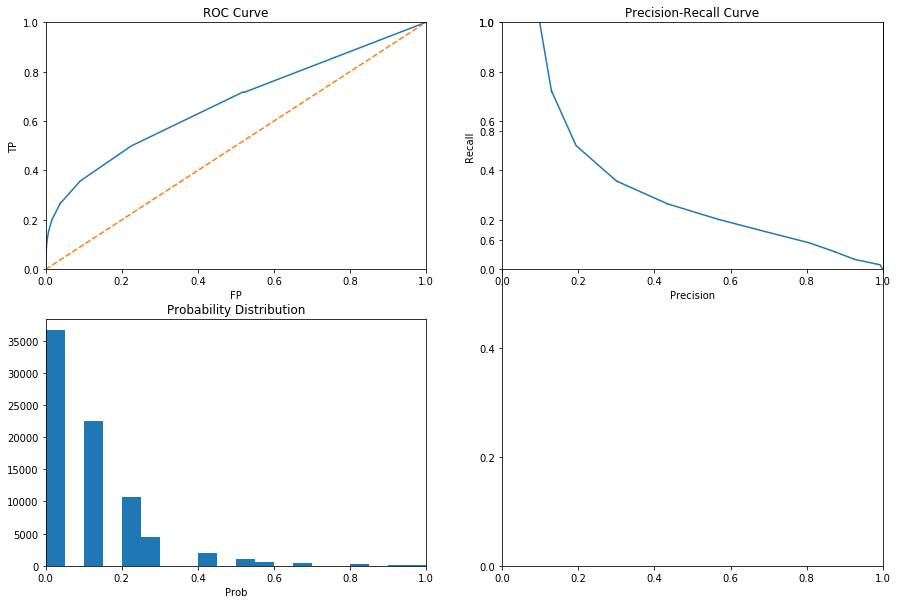

In [311]:
rf = RandomForestClassifier(random_state=33)
precision,recall,y_pred,y_test = train_model(X,y,rf)

In [331]:
# Round 3 Cross Validation and Hyperparameter tuning

param_dist = {"max_depth": np.arange(2,6),
              "max_features": np.arange(4,8),
              "min_samples_split": np.arange(2,11),
              "min_samples_leaf": np.arange(1, 11),
              "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(n_jobs=2)
random_search = RandomizedSearchCV(rf,scoring='precision',param_distributions= param_dist,n_iter=10,n_jobs=2,cv=5)
%time random_search.fit(X.astype(float),y.astype(float))

Wall time: 38.8 s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'max_depth': array([2, 3, 4, 5]), 'max_features': array([4, 5, 6, 7]), 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='precision', verbose=0)

In [332]:
random_search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 7,
 'min_samples_leaf': 9,
 'min_samples_split': 6}

In [334]:
rf = RandomForestClassifier(**random_search.best_params_)
